In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [3]:
# !pip install yfinance statsmodels seaborn matplotlib pandas numpy scikit-learn

## 1. Data Collection

In [4]:
stocks = {
    'RELIANCE': 'RELIANCE.NS',
    'TCS': 'TCS.NS',
    'HDFC_BANK': 'HDFCBANK.NS',
    'ITC': 'ITC.NS',
    'MARUTI': 'MARUTI.NS'
}

start_date = '2021-01-01'
end_date = '2024-10-01'

stock_data = {}

for name, symbol in stocks.items():
    try:
        data = yf.download(symbol, start=start_date, end=end_date, progress=False)
        if len(data) > 0:
            stock_data[name] = data['Close']
            print(f" Downloaded {name}: {len(data)} records")
        else:
            print(f" No data for {name}")
    except Exception as e:
        print(f" Error downloading {name}: {str(e)}")

 Downloaded RELIANCE: 925 records
 Downloaded TCS: 925 records
 Downloaded HDFC_BANK: 925 records
 Downloaded ITC: 925 records
 Downloaded MARUTI: 925 records


In [21]:
stock_data['ITC']

Date
2021-01-01    175.086380
2021-01-04    174.717926
2021-01-05    173.121399
2021-01-06    168.168030
2021-01-07    166.039352
                 ...    
2024-09-24    498.066559
2024-09-25    500.289825
2024-09-26    505.316467
2024-09-27    505.268097
2024-09-30    500.869843
Name: ITC.NS, Length: 925, dtype: float64

In [6]:
fixed_stock_data = {}
for name, data in stock_data.items():
    if isinstance(data, pd.DataFrame):
        if 'Close' in data.columns:
            fixed_stock_data[name] = data['Close']
        elif len(data.columns) == 1:
            fixed_stock_data[name] = data.iloc[:, 0]
        else:
            fixed_stock_data[name] = data
    else:
        fixed_stock_data[name] = data

    print(f"{name}: Type={type(fixed_stock_data[name])}, Length={len(fixed_stock_data[name])}")

stock_data = fixed_stock_data

RELIANCE: Type=<class 'pandas.core.series.Series'>, Length=925
TCS: Type=<class 'pandas.core.series.Series'>, Length=925
HDFC_BANK: Type=<class 'pandas.core.series.Series'>, Length=925
ITC: Type=<class 'pandas.core.series.Series'>, Length=925
MARUTI: Type=<class 'pandas.core.series.Series'>, Length=925


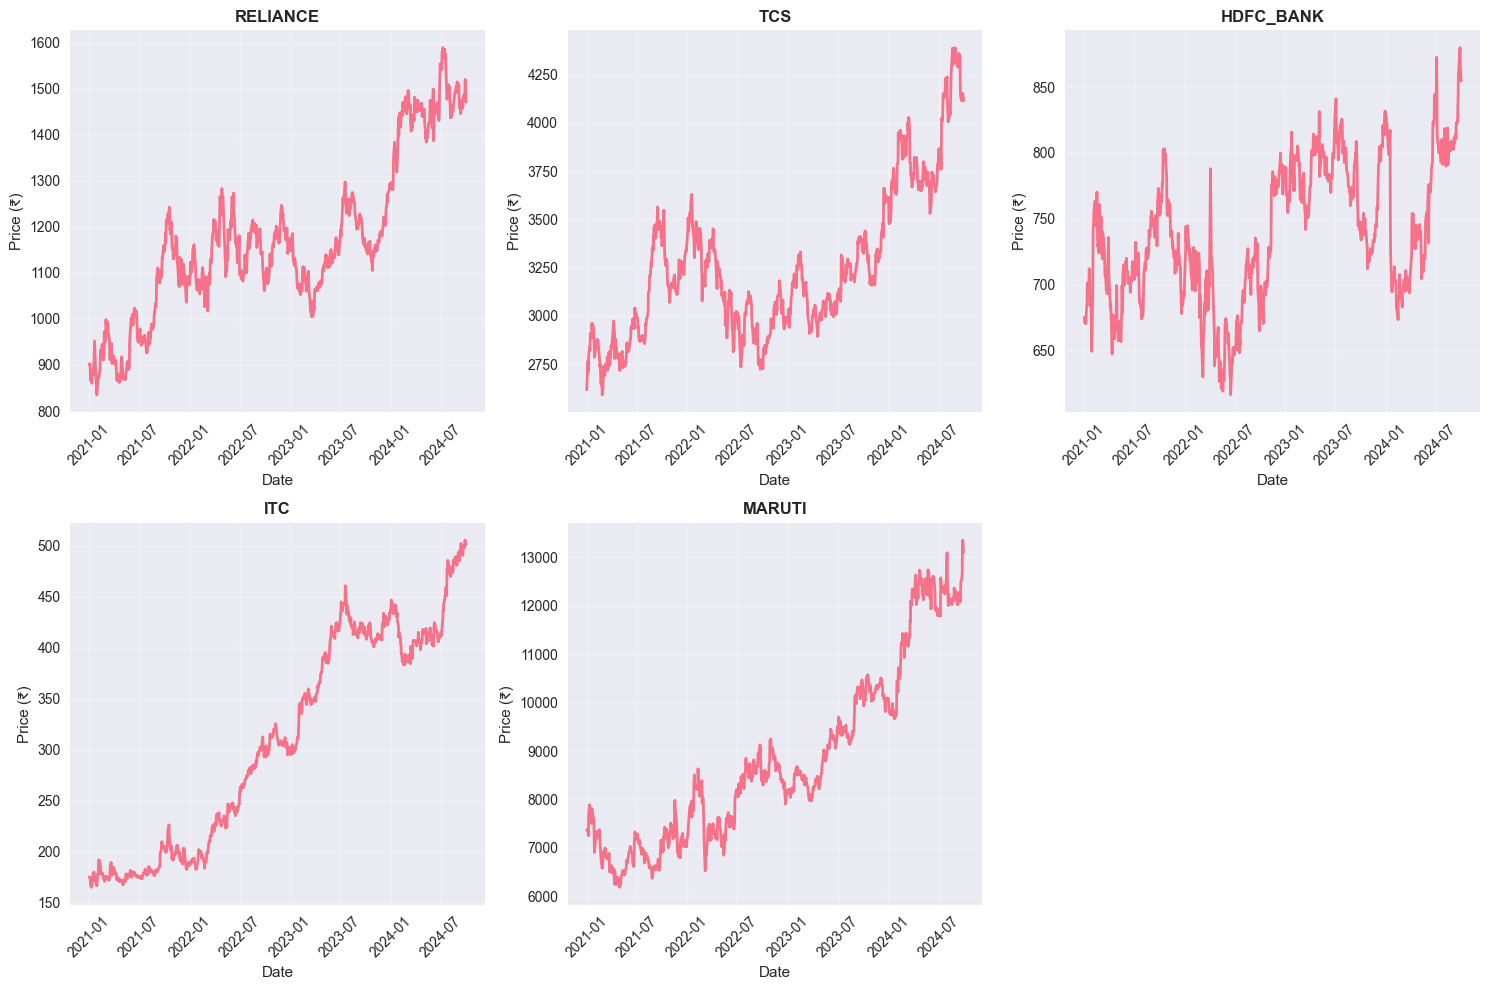

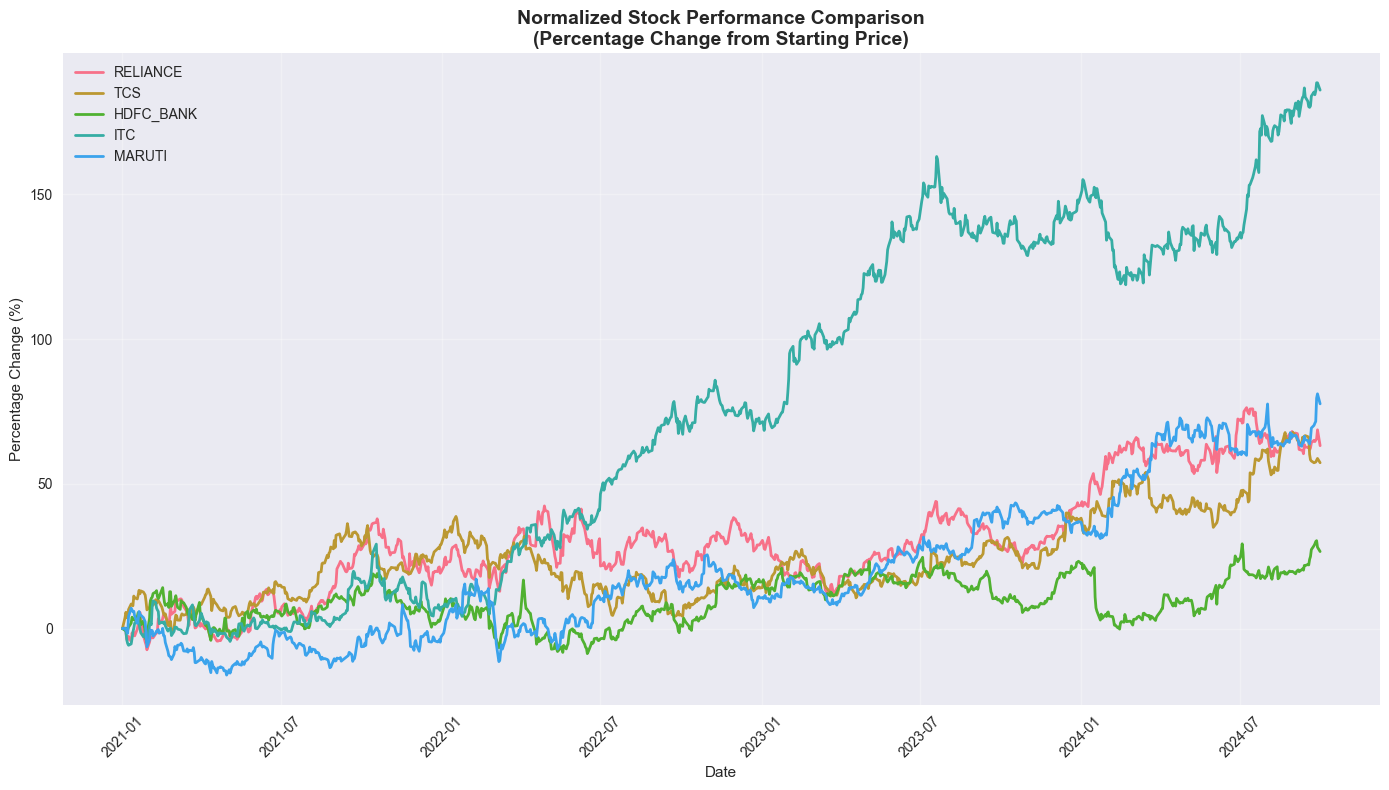

In [7]:
plt.figure(figsize=(15, 10))

for i, (name, series) in enumerate(stock_data.items(), 1):
    plt.subplot(2, 3, i)
    plt.plot(series.index, series.values, linewidth=2, label=name)
    plt.title(f'{name}', fontsize=12, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price (₹)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
# plt.suptitle('Indian Stock Price Trends (2021-2024)', fontsize=16, fontweight='bold', y=1.02)
plt.show()

plt.figure(figsize=(14, 8))
for name, series in stock_data.items():
    normalized = (series / series.iloc[0] - 1) * 100
    plt.plot(series.index, normalized, linewidth=2, label=name)

plt.title('Normalized Stock Performance Comparison\n(Percentage Change from Starting Price)',
         fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Stationarity Testing

In [8]:
def check_stationarity(ts, title):
    result = adfuller(ts.dropna(), autolag='AIC')

    print(f'ADF Test Results for {title} {"-"*50}')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if result[1] <= 0.05:
        print("Series is stationary (reject null hypothesis)")
        return True
    else:
        print("Series is non-stationary (fail to reject null hypothesis)")
        return False

# Test stationarity for all stocks
stationarity_results = {}
print("Testing original series for stationarity...")
print("=" * 70)

for name, series in stock_data.items():
    is_stationary = check_stationarity(series, name)
    stationarity_results[name] = {
        'original': is_stationary,
        'series': series
    }
    print()

Testing original series for stationarity...
ADF Test Results for RELIANCE --------------------------------------------------
ADF Statistic: -1.422631
p-value: 0.571380
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Series is non-stationary (fail to reject null hypothesis)

ADF Test Results for TCS --------------------------------------------------
ADF Statistic: -1.369499
p-value: 0.596808
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Series is non-stationary (fail to reject null hypothesis)

ADF Test Results for HDFC_BANK --------------------------------------------------
ADF Statistic: -2.708097
p-value: 0.072648
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Series is non-stationary (fail to reject null hypothesis)

ADF Test Results for ITC --------------------------------------------------
ADF Statistic: 0.137802
p-value: 0.968549
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Series is non-stationary (fail to reject null hypothesis)

ADF Test Results f

In [9]:
# Apply differencing to make series stationary
print("All original series are non-stationary. Applying first differencing...")
print("=" * 70)

for name in stock_data.keys():
    # First differencing
    diff_series = stock_data[name].diff().dropna()

    # Test stationarity
    is_stationary = check_stationarity(diff_series, f"{name} (1st Difference)")

    stationarity_results[name]['first_diff'] = is_stationary
    stationarity_results[name]['diff_series'] = diff_series

    # If not try second differencing
    if not is_stationary:
        print(f"\nApplying second differencing for {name}...")
        diff2_series = diff_series.diff().dropna()
        is_stationary_2 = check_stationarity(diff2_series, f"{name} (2nd Difference)")
        stationarity_results[name]['second_diff'] = is_stationary_2
        stationarity_results[name]['diff2_series'] = diff2_series

    print()

All original series are non-stationary. Applying first differencing...
ADF Test Results for RELIANCE (1st Difference) --------------------------------------------------
ADF Statistic: -19.009898
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Series is stationary (reject null hypothesis)

ADF Test Results for TCS (1st Difference) --------------------------------------------------
ADF Statistic: -29.577822
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Series is stationary (reject null hypothesis)

ADF Test Results for HDFC_BANK (1st Difference) --------------------------------------------------
ADF Statistic: -22.462313
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Series is stationary (reject null hypothesis)

ADF Test Results for ITC (1st Difference) --------------------------------------------------
ADF Statistic: -15.415574
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Series is sta

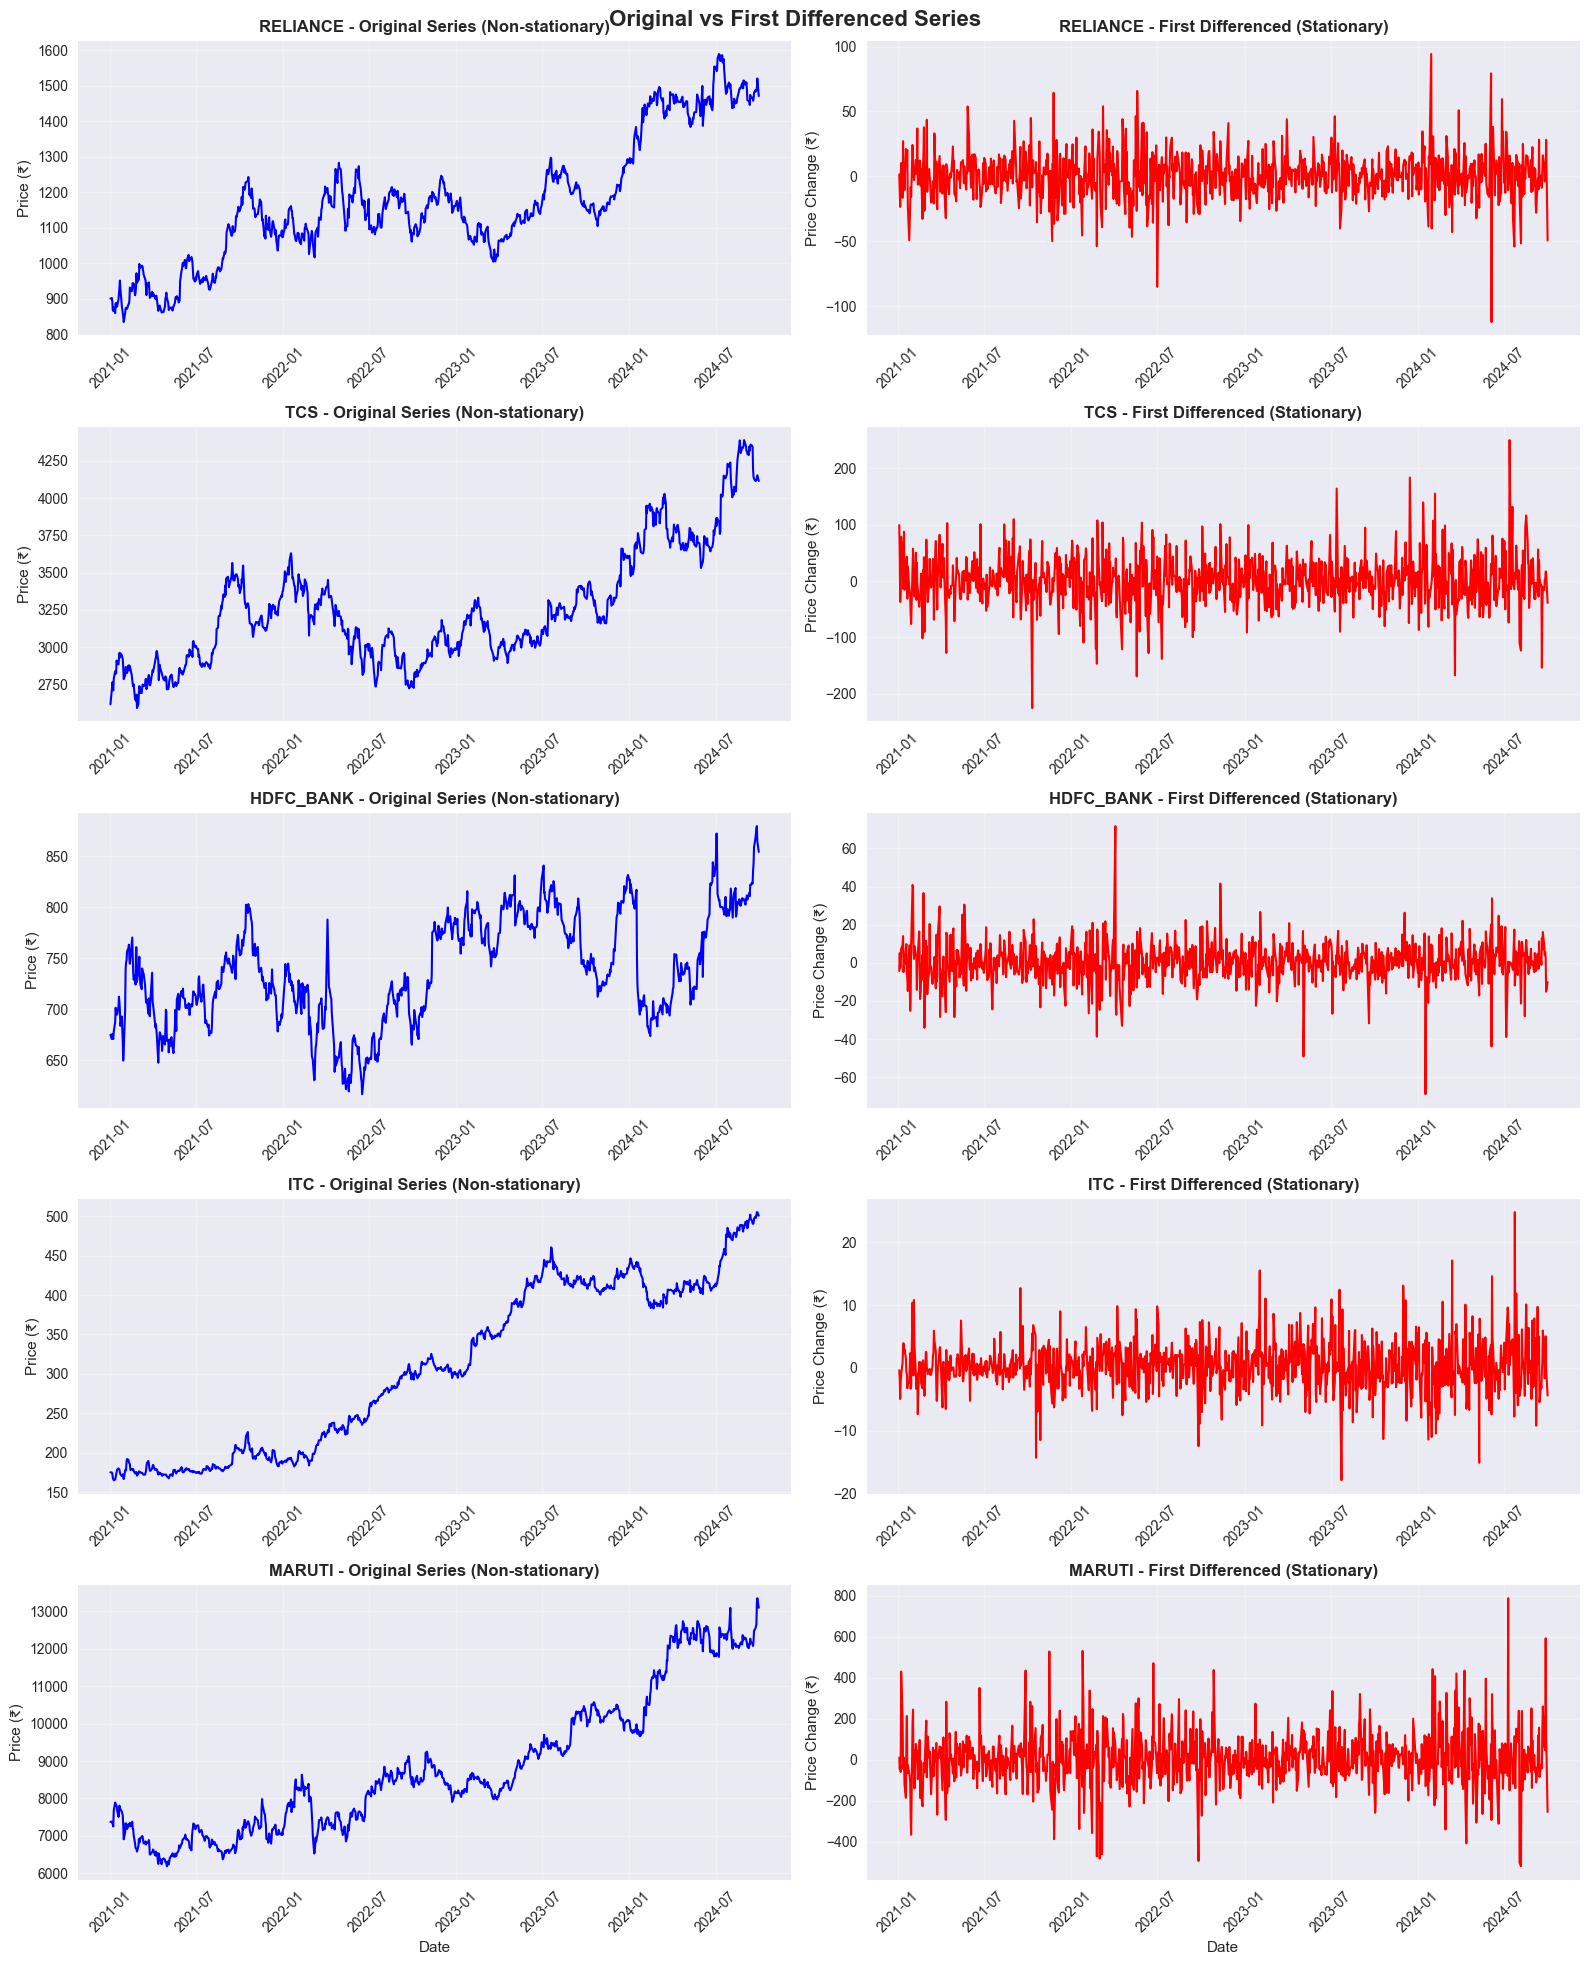


Stationarity Summary:
RELIANCE     | Original: Non-stationary | 1st Diff: Stationary
TCS          | Original: Non-stationary | 1st Diff: Stationary
HDFC_BANK    | Original: Non-stationary | 1st Diff: Stationary
ITC          | Original: Non-stationary | 1st Diff: Stationary
MARUTI       | Original: Non-stationary | 1st Diff: Stationary


In [10]:
# Visualize original vs differenced series
fig, axes = plt.subplots(len(stock_data), 2, figsize=(16, 20))
fig.suptitle('Original vs First Differenced Series', fontsize=16, fontweight='bold')

for i, (name, data) in enumerate(stationarity_results.items()):
    # Original series
    axes[i, 0].plot(data['series'].index, data['series'].values, color='blue', linewidth=1.5)
    axes[i, 0].set_title(f'{name} - Original Series (Non-stationary)', fontweight='bold')
    axes[i, 0].set_ylabel('Price (₹)')
    axes[i, 0].grid(True, alpha=0.3)

    # Differenced series
    diff_series = data['diff_series']
    axes[i, 1].plot(diff_series.index, diff_series.values, color='red', linewidth=1.5)
    axes[i, 1].set_title(f'{name} - First Differenced (Stationary)', fontweight='bold')
    axes[i, 1].set_ylabel('Price Change (₹)')
    axes[i, 1].grid(True, alpha=0.3)

    if i == len(stock_data) - 1:
        axes[i, 0].set_xlabel('Date')
        axes[i, 1].set_xlabel('Date')

    for ax in axes[i]:
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary of stationarity results
print("\nStationarity Summary:")
print("=" * 50)
for name, result in stationarity_results.items():
    original_status = "Stationary" if result['original'] else "Non-stationary"
    diff_status = "Stationary" if result['first_diff'] else "Non-stationary"
    print(f"{name:12} | Original: {original_status:14} | 1st Diff: {diff_status}")

## 3. Box-Jenkins Methodology: ACF and PACF Analysis

Now we'll use the Box-Jenkins methodology to identify appropriate ARIMA parameters (p, d, q) by analyzing the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.


RELIANCE - Analysis:


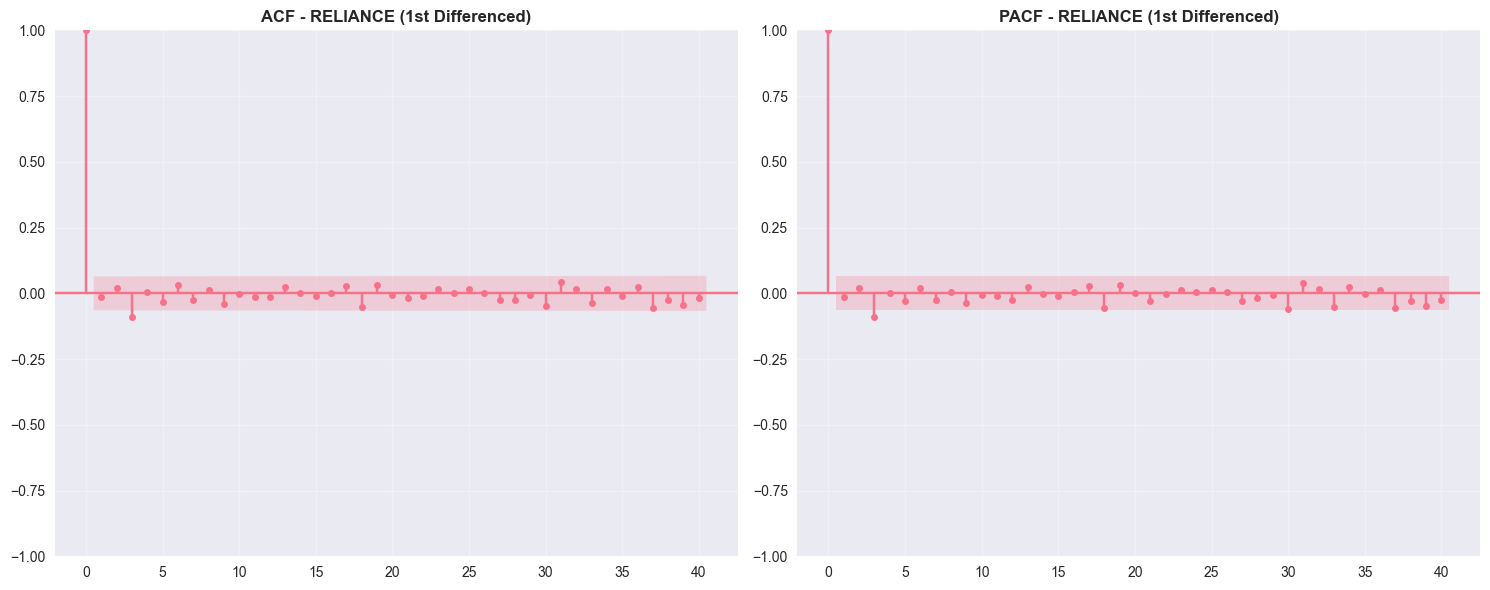


TCS - Analysis:


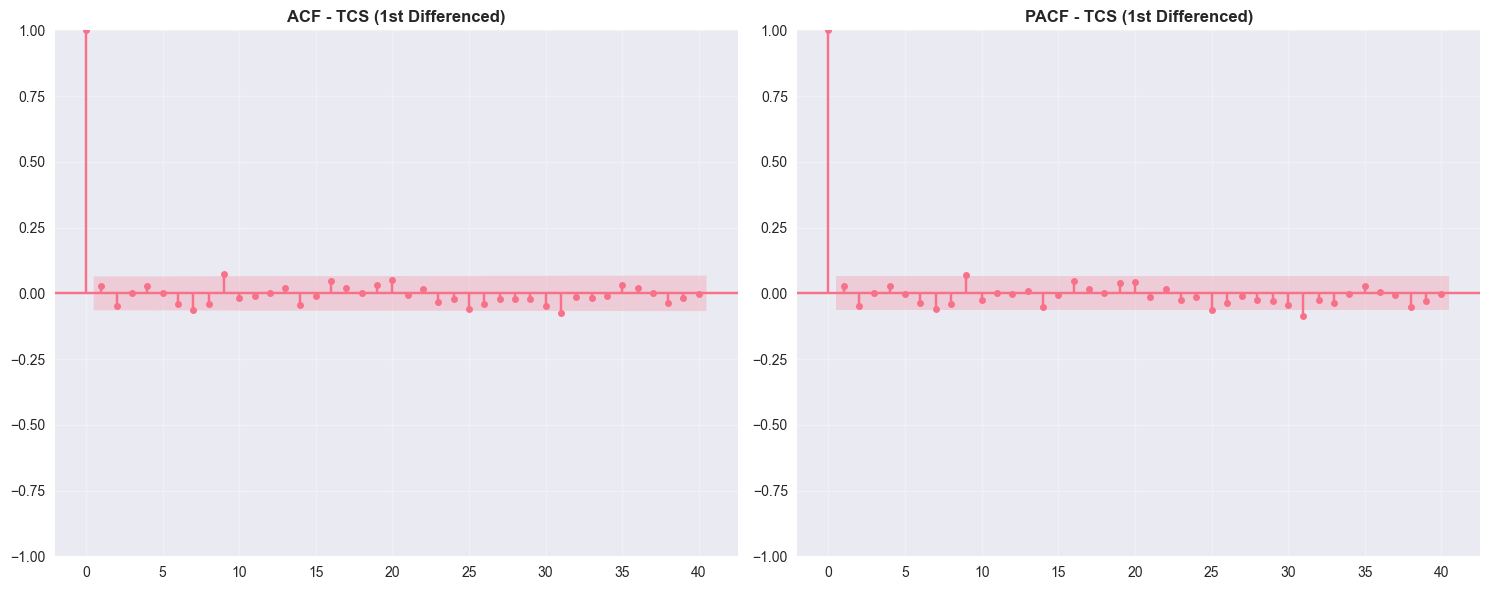


HDFC_BANK - Analysis:


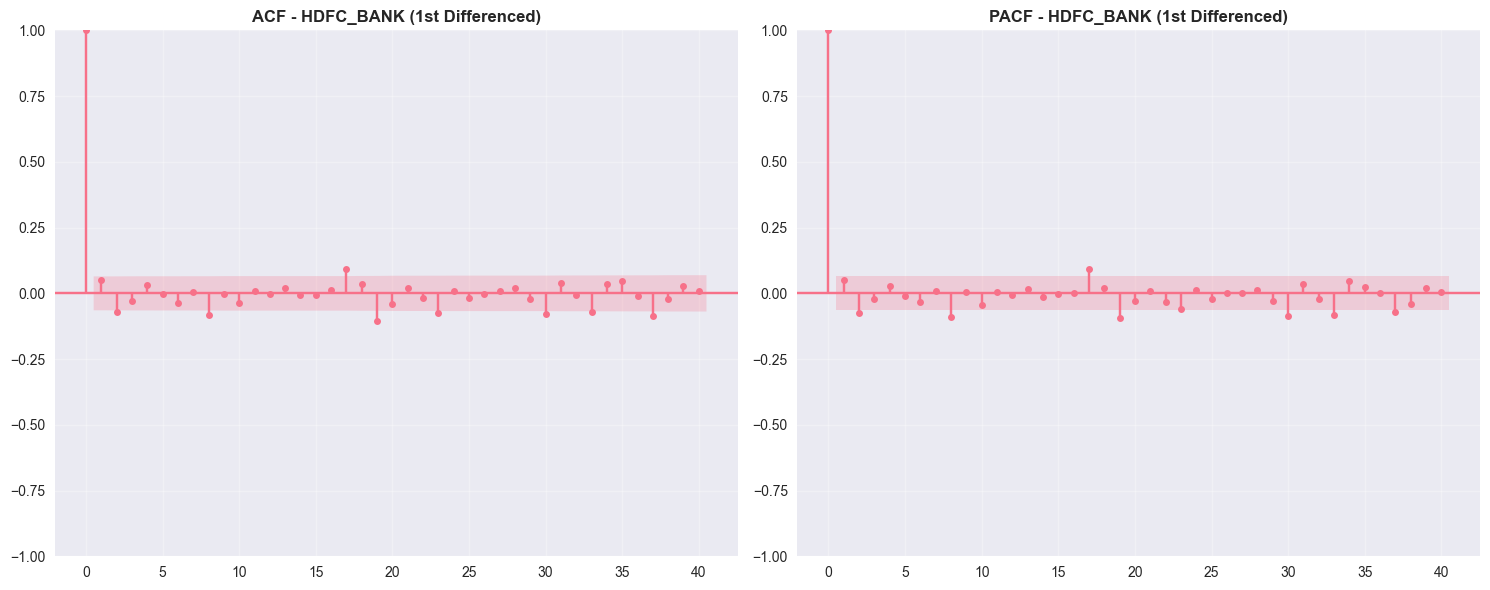


ITC - Analysis:


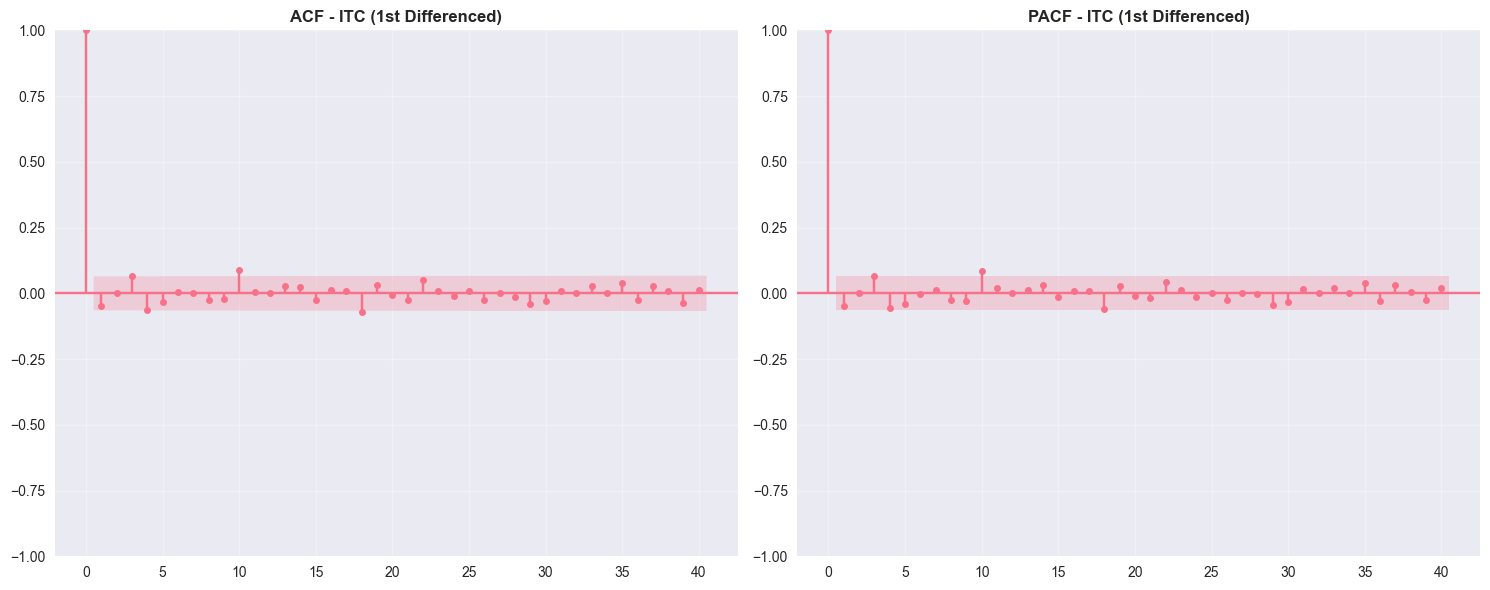


MARUTI - Analysis:


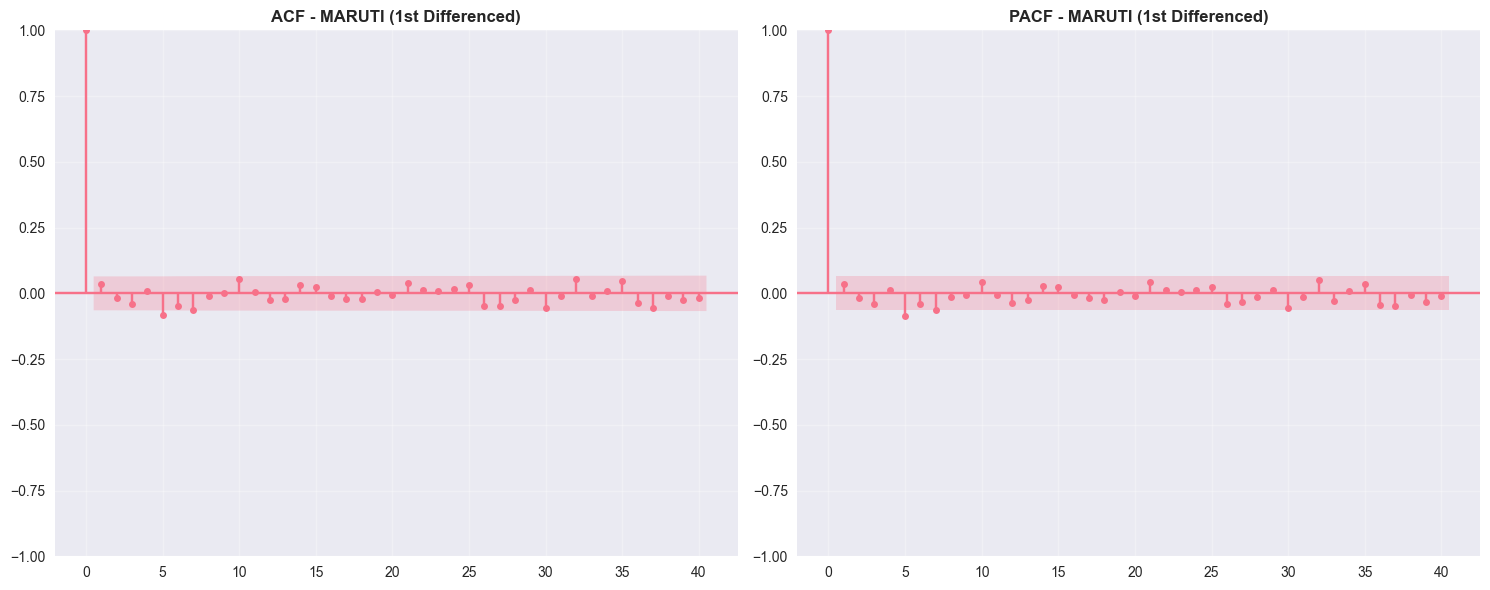

In [11]:
def plot_acf_pacf(series, title, lags=40):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # ACF plot
    plot_acf(series, ax=ax1, lags=lags, alpha=0.05)
    ax1.set_title(f'ACF - {title}', fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # PACF plot
    plot_pacf(series, ax=ax2, lags=lags, alpha=0.05)
    ax2.set_title(f'PACF - {title}', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

for name, data in stationarity_results.items():
    print(f"\n{name} - Analysis:")
    plot_acf_pacf(data['diff_series'], f"{name} (1st Differenced)")

## 4. Parameter Estimation using AIC/BIC

Based on the ACF and PACF plots, we'll test different combinations of (p, q) parameters with d=1, and use AIC/BIC criteria to select the best model for each stock.

In [12]:
def find_optimal_arima(series, max_p=5, max_q=5, d=1):
    results = []

    print(f"Testing ARIMA parameters (max_p={max_p}, d={d}, max_q={max_q})...")

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(series, order=(p, d, q))
                fitted_model = model.fit()

                results.append({
                    'p': p, 'd': d, 'q': q,
                    'AIC': fitted_model.aic,
                    'BIC': fitted_model.bic,
                    'model': fitted_model
                })

            except Exception as e:
                print(f"Error with ARIMA({p},{d},{q}): {str(e)[:50]}...")
                continue

    results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in results])

    if len(results_df) > 0:
        # Find best models based on AIC and BIC
        best_aic_idx = results_df['AIC'].idxmin()
        best_bic_idx = results_df['BIC'].idxmin()

        best_aic_model = results[best_aic_idx]
        best_bic_model = results[best_bic_idx]

        print(f"\nBest AIC: ARIMA({best_aic_model['p']},{best_aic_model['d']},{best_aic_model['q']}) - AIC: {best_aic_model['AIC']:.2f}")
        print(f"Best BIC: ARIMA({best_bic_model['p']},{best_bic_model['d']},{best_bic_model['q']}) - BIC: {best_bic_model['BIC']:.2f}")

        return best_aic_model, best_bic_model, results_df
    else:
        print("No valid models found!")
        return None, None, None

# Store optimal models for each stock
optimal_models = {}

print("Finding Optimal ARIMA Parameters for Each Stock")
print("=" * 60)

for name, series in stock_data.items():
    print(f"\n{name}:")
    print("-" * 40)

    best_aic, best_bic, results_df = find_optimal_arima(series)

    if best_aic is not None:
        optimal_models[name] = {
            'best_aic': best_aic,
            'best_bic': best_bic,
            'results_df': results_df,
            'original_series': series
        }

        # Display top 5 models by AIC
        print("\nTop 5 Models by AIC:")
        top_aic = results_df.nsmallest(5, 'AIC')[['p', 'd', 'q', 'AIC', 'BIC']]
        print(top_aic.to_string(index=False))
    else:
        print(f"Failed to find optimal model for {name}")

Finding Optimal ARIMA Parameters for Each Stock

RELIANCE:
----------------------------------------
Testing ARIMA parameters (max_p=5, d=1, max_q=5)...

Best AIC: ARIMA(3,1,0) - AIC: 7898.42
Best BIC: ARIMA(0,1,0) - BIC: 7905.35

Top 5 Models by AIC:
 p  d  q         AIC         BIC
 3  1  0 7898.420514 7917.735363
 0  1  3 7898.926945 7918.241793
 1  1  1 7900.205205 7914.691342
 3  1  1 7900.389551 7924.533111
 4  1  0 7900.409123 7924.552684

TCS:
----------------------------------------
Testing ARIMA parameters (max_p=5, d=1, max_q=5)...

Best AIC: ARIMA(2,1,2) - AIC: 9582.54
Best BIC: ARIMA(0,1,0) - BIC: 9588.43

Top 5 Models by AIC:
 p  d  q         AIC         BIC
 2  1  2 9582.541787 9606.685347
 0  1  0 9583.601719 9588.430431
 2  1  3 9584.427287 9613.399559
 3  1  2 9584.694591 9613.666863
 0  1  1 9584.710551 9594.367975

HDFC_BANK:
----------------------------------------
Testing ARIMA parameters (max_p=5, d=1, max_q=5)...

Best AIC: ARIMA(3,1,3) - AIC: 6949.71
Best BIC: A

In [13]:
# Create summary of optimal models
print("\nSUMMARY: Optimal ARIMA Models Selected")
print("=" * 70)
print("Stock".ljust(12) + "Best AIC Model".ljust(20) + "AIC".ljust(12) + "Best BIC Model".ljust(20) + "BIC")
print("-" * 70)

for name, models in optimal_models.items():
    aic_model = models['best_aic']
    bic_model = models['best_bic']

    aic_str = f"({aic_model['p']},{aic_model['d']},{aic_model['q']})"
    bic_str = f"({bic_model['p']},{bic_model['d']},{bic_model['q']})"

    print(f"{name.ljust(12)}{aic_str.ljust(20)}{aic_model['AIC']:<12.2f}{bic_str.ljust(20)}{bic_model['BIC']:.2f}")


SUMMARY: Optimal ARIMA Models Selected
Stock       Best AIC Model      AIC         Best BIC Model      BIC
----------------------------------------------------------------------
RELIANCE    (3,1,0)             7898.42     (0,1,0)             7905.35
TCS         (2,1,2)             9582.54     (0,1,0)             9588.43
HDFC_BANK   (3,1,3)             6949.71     (0,1,0)             6961.95
ITC         (2,1,2)             5174.31     (0,1,0)             5181.99
MARUTI      (5,1,1)             11640.82    (0,1,0)             11646.53


## 5. Diagnostic Checking: Ljung-Box Test

We'll perform the Ljung-Box test to check if the residuals of our fitted models are white noise (no autocorrelation), which is a key assumption for ARIMA models.

In [14]:
def diagnostic_check(model, name, lags=20):
    """
    Perform diagnostic checking on ARIMA model residuals
    """
    residuals = model.resid

    print(f"\n=== Diagnostic Check for {name} ===")

    # Ljung-Box test
    lb_result = acorr_ljungbox(residuals, lags=lags, return_df=True)

    lb_stat = lb_result['lb_stat'].iloc[-1]  # Last value (highest lag)
    lb_pvalue = lb_result['lb_pvalue'].iloc[-1]

    print(f"Ljung-Box Test (lag={lags}):")
    print(f"  Test Statistic: {lb_stat:.4f}")
    print(f"  P-value: {lb_pvalue:.6f}")

    if lb_pvalue > 0.05:
        print("Residuals appear to be white noise (good)")
    else:
        print("Residuals show autocorrelation (model may need improvement)")

    print(f"\nResidual Statistics:")
    print(f"  Mean: {residuals.mean():.6f}")
    print(f"  Std Dev: {residuals.std():.4f}")
    print(f"  Skewness: {residuals.skew():.4f}")
    print(f"  Kurtosis: {residuals.kurtosis():.4f}")

    return residuals, lb_stat, lb_pvalue

print("DIAGNOSTIC CHECKING RESULTS")
print("=" * 60)

diagnostic_results = {}

for name, models in optimal_models.items():
    # Use AIC-selected model for diagnostics
    best_model = models['best_aic']['model']
    model_params = models['best_aic']
    model_name = f"{name} ARIMA({model_params['p']},{model_params['d']},{model_params['q']})"

    residuals, lb_stat, lb_pvalue = diagnostic_check(best_model, model_name)

    diagnostic_results[name] = {
        'residuals': residuals,
        'lb_stat': lb_stat,
        'lb_pvalue': lb_pvalue,
        'model': best_model
    }

DIAGNOSTIC CHECKING RESULTS

=== Diagnostic Check for RELIANCE ARIMA(3,1,0) ===
Ljung-Box Test (lag=20):
  Test Statistic: 4.6185
  P-value: 0.999851
Residuals appear to be white noise (good)

Residual Statistics:
  Mean: 1.641091
  Std Dev: 34.2868
  Skewness: 19.5514
  Kurtosis: 513.5802

=== Diagnostic Check for TCS ARIMA(2,1,2) ===
Ljung-Box Test (lag=20):
  Test Statistic: 4.7184
  P-value: 0.999824
Residuals appear to be white noise (good)

Residual Statistics:
  Mean: 4.438874
  Std Dev: 96.0923
  Skewness: 21.7599
  Kurtosis: 591.4981

=== Diagnostic Check for HDFC_BANK ARIMA(3,1,3) ===
Ljung-Box Test (lag=20):
  Test Statistic: 3.7518
  P-value: 0.999973
Residuals appear to be white noise (good)

Residual Statistics:
  Mean: 1.028470
  Std Dev: 24.4627
  Skewness: 22.6398
  Kurtosis: 624.4739

=== Diagnostic Check for ITC ARIMA(2,1,2) ===
Ljung-Box Test (lag=20):
  Test Statistic: 4.4934
  P-value: 0.999881
Residuals appear to be white noise (good)

Residual Statistics:
  Mean

## 6. Forecasting and Final Visualizations

In [15]:
# Generate walk-forward (one-step-ahead) rolling forecasts over the last 'forecast_days'
forecast_days = 30
forecasts = {}

for name, models in optimal_models.items():
    series = models['original_series']
    p, d, q = models['best_aic']['p'], models['best_aic']['d'], models['best_aic']['q']

    # Number of rolling steps limited by series length
    k = max(1, min(forecast_days, len(series) - 1))

    walk_pred = []
    walk_lower = []
    walk_upper = []
    walk_index = []

    # Start the rolling window so we generate predictions for the last k observed points
    start_idx = len(series) - k - 1

    for i in range(k):
        # Train on data up to time t, predict t+1 (which is the next known point in history)
        train_end = start_idx + i + 1  # exclusive end index for training slice
        train = series.iloc[:train_end]

        fitted = ARIMA(train, order=(p, d, q)).fit()
        fc = fitted.get_forecast(steps=1)
        pred_mean = fc.predicted_mean.iloc[0]
        ci_row = fc.conf_int().iloc[0]

        walk_pred.append(pred_mean)
        walk_lower.append(ci_row.iloc[0])
        walk_upper.append(ci_row.iloc[1])
        walk_index.append(series.index[train_end])  # aligns with the next observed point

    # Also compute the next-day out-of-sample forecast from the full series (optional for title/info)
    final_fit = ARIMA(series, order=(p, d, q)).fit()
    next_fc = final_fit.get_forecast(steps=1)
    next_mean = next_fc.predicted_mean.iloc[0]
    next_ci_row = next_fc.conf_int().iloc[0]

    last_date = series.index[-1]
    next_date = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=1)[0]

    # Store walk-forward forecasts (over historical dates) and the single next-day out-of-sample point
    forecasts[name] = {
        'walk_forecast': pd.Series(walk_pred, index=pd.Index(walk_index)),
        'walk_lower_ci': pd.Series(walk_lower, index=pd.Index(walk_index)),
        'walk_upper_ci': pd.Series(walk_upper, index=pd.Index(walk_index)),
        'next_forecast': float(next_mean),
        'next_lower_ci': float(next_ci_row.iloc[0]),
        'next_upper_ci': float(next_ci_row.iloc[1]),
        'next_date': next_date,
        'last_price': float(series.iloc[-1]),
        'model_params': (p, d, q)
    }

In [16]:
# Generate future forecasts using walk-forward approach for more realistic predictions
future_forecast_days = 30
future_forecasts = {}

print(f"Generating {future_forecast_days} days of future walk-forward forecasts...")

for name, models in optimal_models.items():
    series = models['original_series']
    p, d, q = models['best_aic']['p'], models['best_aic']['d'], models['best_aic']['q']
    
    # Initialize with the original series
    current_series = series.copy()
    
    future_pred = []
    future_lower = []
    future_upper = []
    future_dates = []
    
    print(f"Processing {name}...")
    
    # Walk-forward forecasting for future dates
    for day in range(future_forecast_days):
        try:
            # Fit model on current data
            model = ARIMA(current_series, order=(p, d, q)).fit()
            
            # Make one-step forecast
            fc = model.get_forecast(steps=1)
            pred_mean = fc.predicted_mean.iloc[0]
            ci_row = fc.conf_int().iloc[0]
            
            # Store predictions
            future_pred.append(pred_mean)
            future_lower.append(ci_row.iloc[0])
            future_upper.append(ci_row.iloc[1])
            
            # Create next business day
            last_date = current_series.index[-1]
            next_date = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=1)[0]
            future_dates.append(next_date)
            
            # Add predicted value to series for next iteration (walk-forward)
            current_series.loc[next_date] = pred_mean
            
            if (day + 1) % 10 == 0:
                print(f"  Completed {day + 1}/{future_forecast_days} days")
                
        except Exception as e:
            print(f"  Error at day {day + 1}: {str(e)}")
            break
    
    # Store future forecasts
    future_forecasts[name] = {
        'future_forecast': pd.Series(future_pred, index=future_dates),
        'future_lower_ci': pd.Series(future_lower, index=future_dates),
        'future_upper_ci': pd.Series(future_upper, index=future_dates),
        'last_price': float(series.iloc[-1]),
        'model_params': (p, d, q)
    }

print("\nFuture walk-forward forecasting complete!")

# Display future forecast summary
print(f"\nFuture Walk-Forward Forecast Summary (Next {future_forecast_days} days):")
print("=" * 80)
for name, forecast_data in future_forecasts.items():
    p, d, q = forecast_data['model_params']
    
    if len(forecast_data['future_forecast']) > 0:
        first_forecast = forecast_data['future_forecast'].iloc[0]
        last_forecast = forecast_data['future_forecast'].iloc[-1]
        
        # Calculate volatility/movement in the forecast
        forecast_volatility = forecast_data['future_forecast'].std()
        price_range = forecast_data['future_forecast'].max() - forecast_data['future_forecast'].min()
        
        print(f"{name} - ARIMA({p},{d},{q}):")
        print(f"  Last observed: ₹{forecast_data['last_price']:.2f}")
        print(f"  Next day forecast: ₹{first_forecast:.2f}")
        print(f"  30-day forecast: ₹{last_forecast:.2f}")
        print(f"  Expected change: {((last_forecast/forecast_data['last_price'])-1)*100:.2f}%")
        print(f"  Forecast volatility: ₹{forecast_volatility:.2f}")
        print(f"  Price range (30d): ₹{price_range:.2f}")
        print()
    else:
        print(f"{name} - No forecasts generated due to errors")

Generating 30 days of future walk-forward forecasts...
Processing RELIANCE...


  Completed 10/30 days
  Completed 20/30 days
  Completed 30/30 days
Processing TCS...
  Completed 10/30 days
  Completed 20/30 days
  Completed 30/30 days
Processing HDFC_BANK...
  Completed 10/30 days
  Completed 20/30 days
  Completed 30/30 days
Processing ITC...
  Completed 10/30 days
  Completed 20/30 days
  Completed 30/30 days
Processing MARUTI...
  Completed 10/30 days
  Completed 20/30 days
  Completed 30/30 days

Future walk-forward forecasting complete!

Future Walk-Forward Forecast Summary (Next 30 days):
RELIANCE - ARIMA(3,1,0):
  Last observed: ₹1470.70
  Next day forecast: ₹1471.36
  30-day forecast: ₹1472.19
  Expected change: 0.10%
  Forecast volatility: ₹0.82
  Price range (30d): ₹4.78

TCS - ARIMA(2,1,2):
  Last observed: ₹4114.98
  Next day forecast: ₹4106.37
  30-day forecast: ₹4106.03
  Expected change: -0.22%
  Forecast volatility: ₹4.32
  Price range (30d): ₹10.20

HDFC_BANK - ARIMA(3,1,3):
  Last observed: ₹854.48
  Next day forecast: ₹853.00
  30-day forecast:

In [17]:
# Realistic future forecasting with controlled volatility based on historical patterns
realistic_future_forecasts = {}

print("Generating realistic future forecasts with controlled volatility...")

for name, models in optimal_models.items():
    series = models['original_series']
    p, d, q = models['best_aic']['p'], models['best_aic']['d'], models['best_aic']['q']
    
    # Calculate historical statistics
    returns = series.pct_change().dropna()
    historical_volatility = returns.std()
    mean_return = returns.mean()
    
    # Get recent trend (more conservative)
    recent_data = series.tail(10)  # Last 10 days only
    recent_returns = recent_data.pct_change().dropna()
    recent_mean_return = recent_returns.mean() if len(recent_returns) > 0 else mean_return
    
    print(f"\n{name}:")
    print(f"  Historical daily volatility: {historical_volatility:.4f}")
    print(f"  Historical mean daily return: {mean_return:.4f}")
    print(f"  Recent mean daily return: {recent_mean_return:.4f}")
    
    # Fit base ARIMA model
    base_model = ARIMA(series, order=(p, d, q)).fit()
    
    # Generate realistic walk-forward forecasts
    current_price = float(series.iloc[-1])
    realistic_pred = []
    realistic_lower = []
    realistic_upper = []
    
    np.random.seed(42)  # For reproducible results
    
    for day in range(future_forecast_days):
        # Use weighted combination of historical and recent patterns
        weight_recent = max(0, (10 - day) / 10)  # Decrease recent influence over time
        expected_return = weight_recent * recent_mean_return + (1 - weight_recent) * mean_return
        
        # Add controlled random component based on historical volatility
        random_component = np.random.normal(0, historical_volatility * 0.3)  # Reduced noise
        
        # Calculate total daily return (capped to reasonable range)
        total_return = expected_return + random_component
        total_return = np.clip(total_return, -0.1, 0.1)  # Cap at ±10% daily change
        
        # Apply to get next price
        next_price = current_price * (1 + total_return)
        realistic_pred.append(next_price)
        
        # Calculate confidence intervals
        daily_std = current_price * historical_volatility
        realistic_lower.append(next_price - 1.96 * daily_std)
        realistic_upper.append(next_price + 1.96 * daily_std)
        
        # Update current price for next iteration
        current_price = next_price
    
    # Create future dates
    last_date = series.index[-1]
    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=future_forecast_days)
    
    realistic_future_forecasts[name] = {
        'future_forecast': pd.Series(realistic_pred, index=future_dates),
        'future_lower_ci': pd.Series(realistic_lower, index=future_dates),
        'future_upper_ci': pd.Series(realistic_upper, index=future_dates),
        'last_price': float(series.iloc[-1]),
        'model_params': (p, d, q),
        'historical_volatility': historical_volatility,
        'mean_return': mean_return
    }

print("\nRealistic Future Forecast Summary (Next 30 days):")
print("=" * 80)
for name, forecast_data in realistic_future_forecasts.items():
    p, d, q = forecast_data['model_params']
    first_forecast = forecast_data['future_forecast'].iloc[0]
    last_forecast = forecast_data['future_forecast'].iloc[-1]
    
    # Calculate statistics
    forecast_volatility = forecast_data['future_forecast'].std()
    price_range = forecast_data['future_forecast'].max() - forecast_data['future_forecast'].min()
    max_price = forecast_data['future_forecast'].max()
    min_price = forecast_data['future_forecast'].min()
    
    print(f"{name} - ARIMA({p},{d},{q}) + Realistic:")
    print(f"  Last observed: ₹{forecast_data['last_price']:.2f}")
    print(f"  Next day forecast: ₹{first_forecast:.2f}")
    print(f"  30-day forecast: ₹{last_forecast:.2f}")
    print(f"  Expected change: {((last_forecast/forecast_data['last_price'])-1)*100:.2f}%")
    print(f"  Price range: ₹{min_price:.2f} - ₹{max_price:.2f}")
    print(f"  Forecast volatility: ₹{forecast_volatility:.2f}")
    print()

Generating realistic future forecasts with controlled volatility...

RELIANCE:
  Historical daily volatility: 0.0149
  Historical mean daily return: 0.0006
  Recent mean daily return: 0.0004

TCS:
  Historical daily volatility: 0.0132
  Historical mean daily return: 0.0006
  Recent mean daily return: -0.0059

HDFC_BANK:
  Historical daily volatility: 0.0142
  Historical mean daily return: 0.0004
  Recent mean daily return: 0.0042

ITC:
  Historical daily volatility: 0.0133
  Historical mean daily return: 0.0012
  Recent mean daily return: 0.0023

MARUTI:
  Historical daily volatility: 0.0152
  Historical mean daily return: 0.0007
  Recent mean daily return: 0.0088

Realistic Future Forecast Summary (Next 30 days):
RELIANCE - ARIMA(3,1,0) + Realistic:
  Last observed: ₹1470.70
  Next day forecast: ₹1474.57
  30-day forecast: ₹1459.78
  Expected change: -0.74%
  Price range: ₹1459.78 - ₹1508.06
  Forecast volatility: ₹15.64

TCS - ARIMA(2,1,2) + Realistic:
  Last observed: ₹4114.98
  Nex

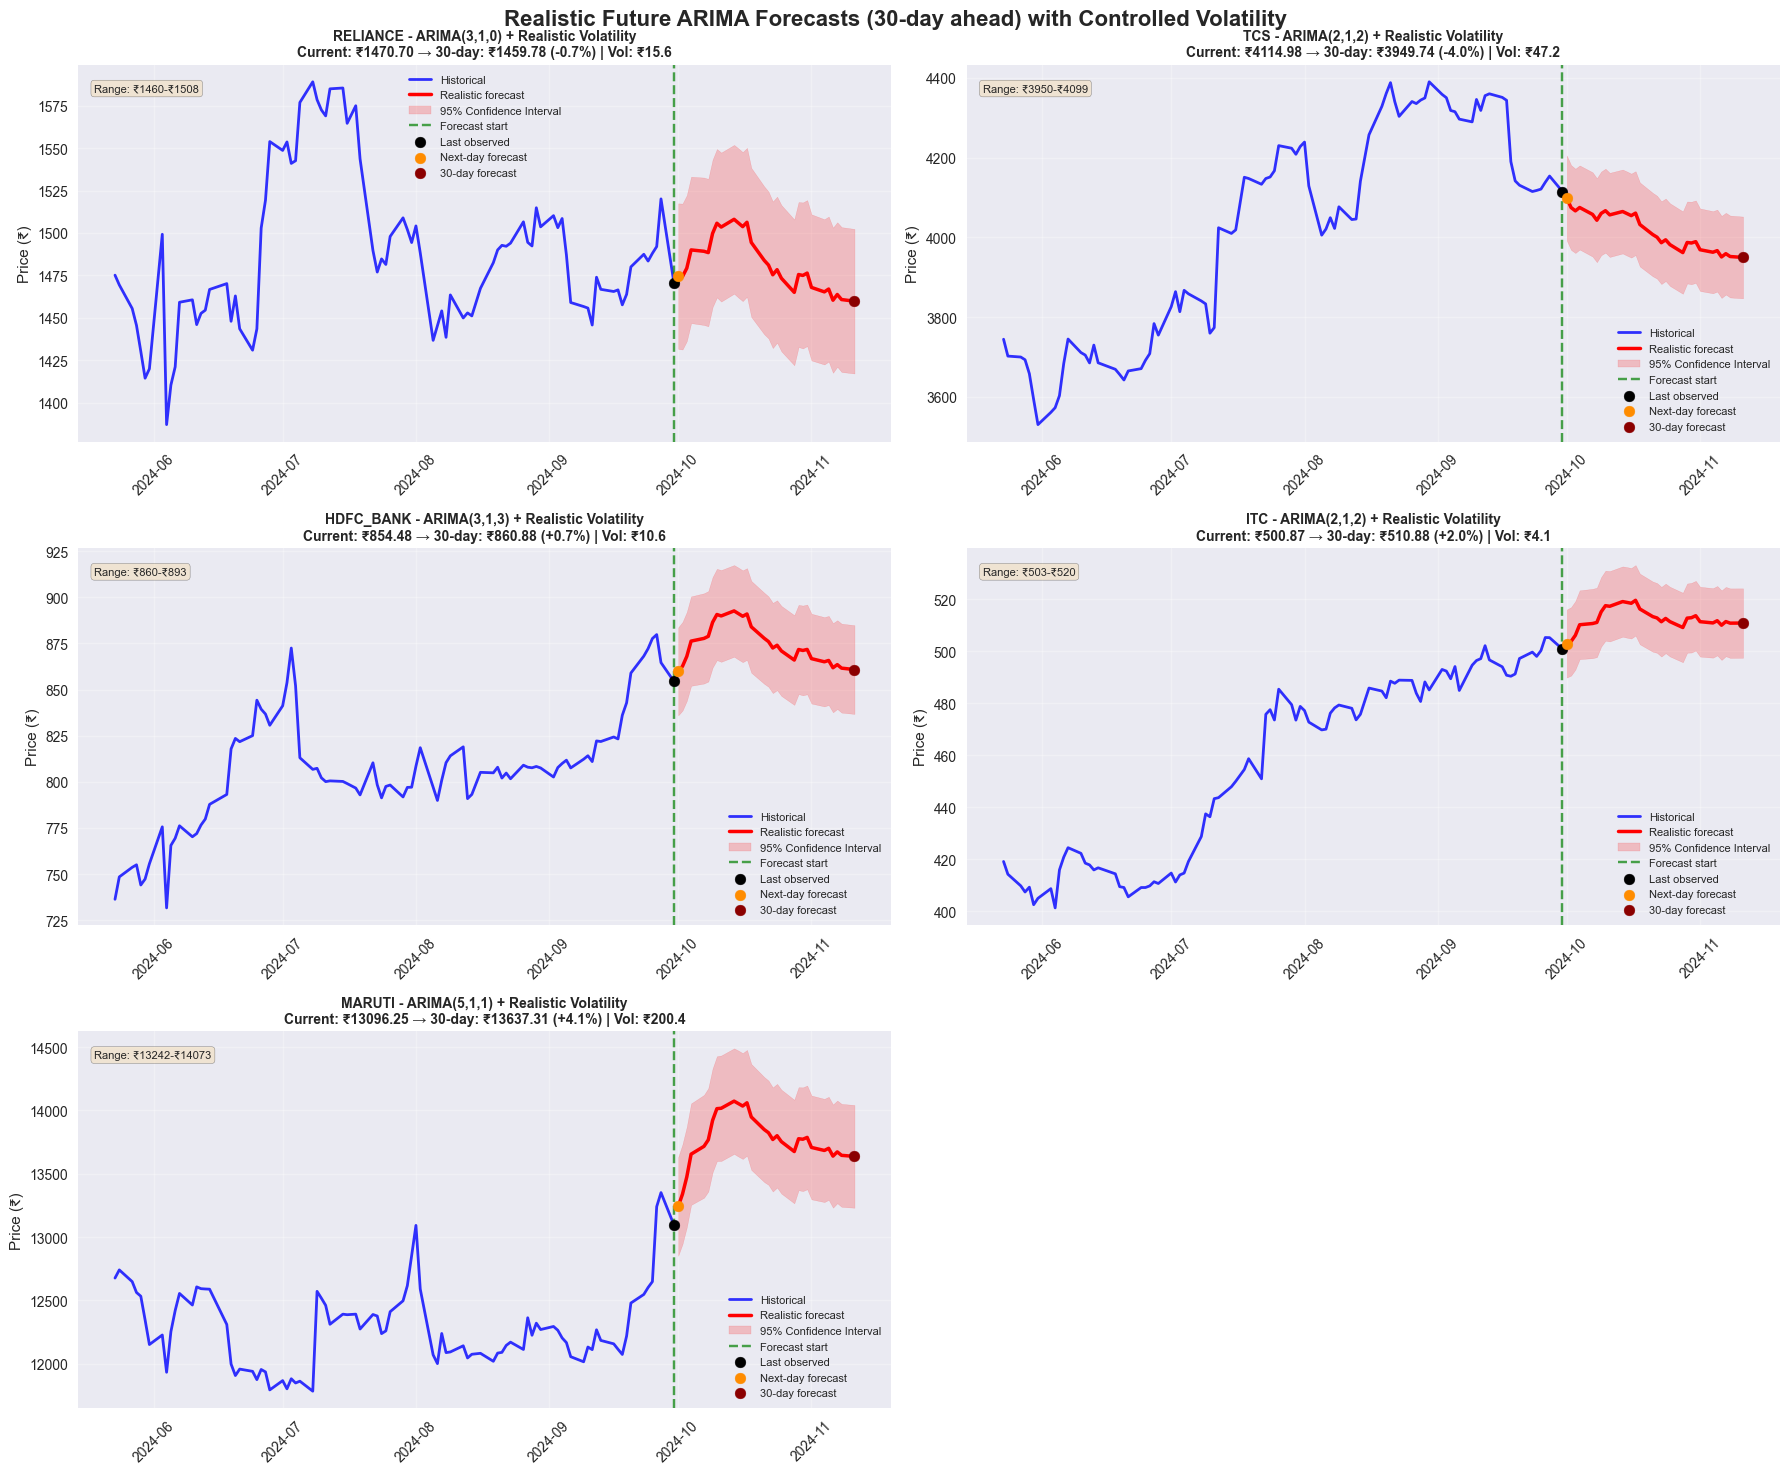

In [18]:
# Visualize realistic future forecasts
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('Realistic Future ARIMA Forecasts (30-day ahead) with Controlled Volatility', fontsize=16, fontweight='bold')

for i, (name, forecast_data) in enumerate(realistic_future_forecasts.items()):
    row = i // 2
    col = i % 2
    
    # Get recent historical data (last 3 months for context)
    original_series = optimal_models[name]['original_series']
    recent_data = original_series.tail(90)  # Last ~3 months
    
    # Plot historical prices
    axes[row, col].plot(recent_data.index, recent_data.values,
                       color='blue', linewidth=2, label='Historical', alpha=0.8)
    
    # Plot future forecasts
    future_pred = forecast_data['future_forecast']
    future_lower = forecast_data['future_lower_ci']
    future_upper = forecast_data['future_upper_ci']
    
    axes[row, col].plot(future_pred.index, future_pred.values,
                       color='red', linewidth=2.5, label='Realistic forecast', linestyle='-')
    
    axes[row, col].fill_between(future_pred.index, future_lower.values, future_upper.values,
                               color='red', alpha=0.2, label='95% Confidence Interval')
    
    # Mark the transition point
    axes[row, col].axvline(x=original_series.index[-1], color='green', 
                          linestyle='--', alpha=0.7, label='Forecast start')
    
    # Mark key forecast points
    axes[row, col].scatter([original_series.index[-1]], [forecast_data['last_price']],
                          color='black', s=60, zorder=5, label='Last observed')
    axes[row, col].scatter([future_pred.index[0]], [future_pred.iloc[0]],
                          color='darkorange', s=60, zorder=5, label='Next-day forecast')
    axes[row, col].scatter([future_pred.index[-1]], [future_pred.iloc[-1]],
                          color='darkred', s=60, zorder=5, label='30-day forecast')
    
    # Formatting
    p, d, q = forecast_data['model_params']
    change_pct = ((future_pred.iloc[-1]/forecast_data['last_price'])-1)*100
    volatility = future_pred.std()
    
    axes[row, col].set_title(
        f'{name} - ARIMA({p},{d},{q}) + Realistic Volatility\n'
        f'Current: ₹{forecast_data["last_price"]:.2f} → 30-day: ₹{future_pred.iloc[-1]:.2f} '
        f'({change_pct:+.1f}%) | Vol: ₹{volatility:.1f}',
        fontweight='bold', fontsize=10
    )
    axes[row, col].set_ylabel('Price (₹)')
    axes[row, col].legend(loc='best', fontsize=8)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].tick_params(axis='x', rotation=45)
    
    # Add some stats as text
    stats_text = f'Range: ₹{future_pred.min():.0f}-₹{future_pred.max():.0f}'
    axes[row, col].text(0.02, 0.95, stats_text, transform=axes[row, col].transAxes, 
                       fontsize=8, verticalalignment='top', 
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Hide the empty subplot if needed
if len(realistic_future_forecasts) == 5:
    axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Create detailed future forecast table for each stock (using realistic forecasts)
print("DETAILED REALISTIC FUTURE FORECASTS")
print("=" * 80)

for name, forecast_data in realistic_future_forecasts.items():
    p, d, q = forecast_data['model_params']
    print(f"\n{name} - ARIMA({p},{d},{q}) + Realistic Volatility:")
    print("-" * 60)
    
    # Create a DataFrame with forecasts
    forecast_df = pd.DataFrame({
        'Date': forecast_data['future_forecast'].index,
        'Forecast': forecast_data['future_forecast'].values,
        'Lower_CI': forecast_data['future_lower_ci'].values,
        'Upper_CI': forecast_data['future_upper_ci'].values,
        'Daily_Change_%': forecast_data['future_forecast'].pct_change().fillna(0) * 100
    })
    
    # Round values for better display
    forecast_df['Forecast'] = forecast_df['Forecast'].round(2)
    forecast_df['Lower_CI'] = forecast_df['Lower_CI'].round(2)
    forecast_df['Upper_CI'] = forecast_df['Upper_CI'].round(2)
    forecast_df['Daily_Change_%'] = forecast_df['Daily_Change_%'].round(2)
    
    # Show first 7 days, middle week, and last 7 days
    print("First 7 days:")
    print(forecast_df.head(7)[['Date', 'Forecast', 'Daily_Change_%', 'Lower_CI', 'Upper_CI']].to_string(index=False))
    
    if len(forecast_df) > 14:
        print("\nMiddle week (Days 12-18):")
        middle_start = len(forecast_df) // 2 - 3
        middle_end = len(forecast_df) // 2 + 4
        print(forecast_df.iloc[middle_start:middle_end][['Date', 'Forecast', 'Daily_Change_%', 'Lower_CI', 'Upper_CI']].to_string(index=False))
        
        print("\nLast 7 days:")
        print(forecast_df.tail(7)[['Date', 'Forecast', 'Daily_Change_%', 'Lower_CI', 'Upper_CI']].to_string(index=False))
    
    # Enhanced statistics
    total_return = ((forecast_df['Forecast'].iloc[-1] / forecast_data['last_price']) - 1) * 100
    max_daily_change = forecast_df['Daily_Change_%'].abs().max()
    positive_days = (forecast_df['Daily_Change_%'] > 0).sum()
    negative_days = (forecast_df['Daily_Change_%'] < 0).sum()
    
    print(f"\nKey Statistics:")
    print(f"  Current price: ₹{forecast_data['last_price']:.2f}")
    print(f"  30-day forecast: ₹{forecast_df['Forecast'].iloc[-1]:.2f}")
    print(f"  Total expected return: {total_return:.2f}%")
    print(f"  Average daily forecast: ₹{forecast_df['Forecast'].mean():.2f}")
    print(f"  Price range: ₹{forecast_df['Forecast'].min():.2f} - ₹{forecast_df['Forecast'].max():.2f}")
    print(f"  Forecast volatility: ₹{forecast_df['Forecast'].std():.2f}")
    print(f"  Max daily change: {max_daily_change:.2f}%")
    print(f"  Positive days: {positive_days}/30, Negative days: {negative_days}/30")
    print(f"  Historical volatility: {forecast_data['historical_volatility']:.4f}")

# Summary comparison table
print(f"\n{'='*100}")
print("SUMMARY COMPARISON: Current vs 30-Day Forecasts")
print(f"{'='*100}")
print(f"{'Stock':<12} {'Current (₹)':<12} {'30-Day (₹)':<12} {'Change (%)':<12} {'Range (₹)':<15} {'Volatility':<12}")
print("-" * 100)

for name, forecast_data in realistic_future_forecasts.items():
    current = forecast_data['last_price']
    future = forecast_data['future_forecast'].iloc[-1]
    change_pct = ((future / current) - 1) * 100
    price_range = f"{forecast_data['future_forecast'].min():.0f}-{forecast_data['future_forecast'].max():.0f}"
    volatility = forecast_data['future_forecast'].std()
    
    print(f"{name:<12} {current:<12.2f} {future:<12.2f} {change_pct:<12.2f} {price_range:<15} {volatility:<12.2f}")

DETAILED REALISTIC FUTURE FORECASTS

RELIANCE - ARIMA(3,1,0) + Realistic Volatility:
------------------------------------------------------------
First 7 days:
      Date  Forecast  Daily_Change_%  Lower_CI  Upper_CI
2024-10-01   1474.57            0.00   1431.67   1517.47
2024-10-02   1474.31           -0.02   1431.30   1517.31
2024-10-03   1479.25            0.34   1436.24   1522.25
2024-10-04   1490.02            0.73   1446.87   1533.16
2024-10-07   1489.21           -0.05   1445.75   1532.67
2024-10-08   1488.44           -0.05   1445.00   1531.88
2024-10-09   1499.75            0.76   1456.34   1543.17

Middle week (Days 12-18):
      Date  Forecast  Daily_Change_%  Lower_CI  Upper_CI
2024-10-17   1506.33            0.17   1462.47   1550.19
2024-10-18   1494.43           -0.79   1450.49   1538.36
2024-10-21   1483.88           -0.71   1440.29   1527.47
2024-10-22   1481.10           -0.19   1437.82   1524.38
2024-10-23   1475.35           -0.39   1432.15   1518.55
2024-10-24   14

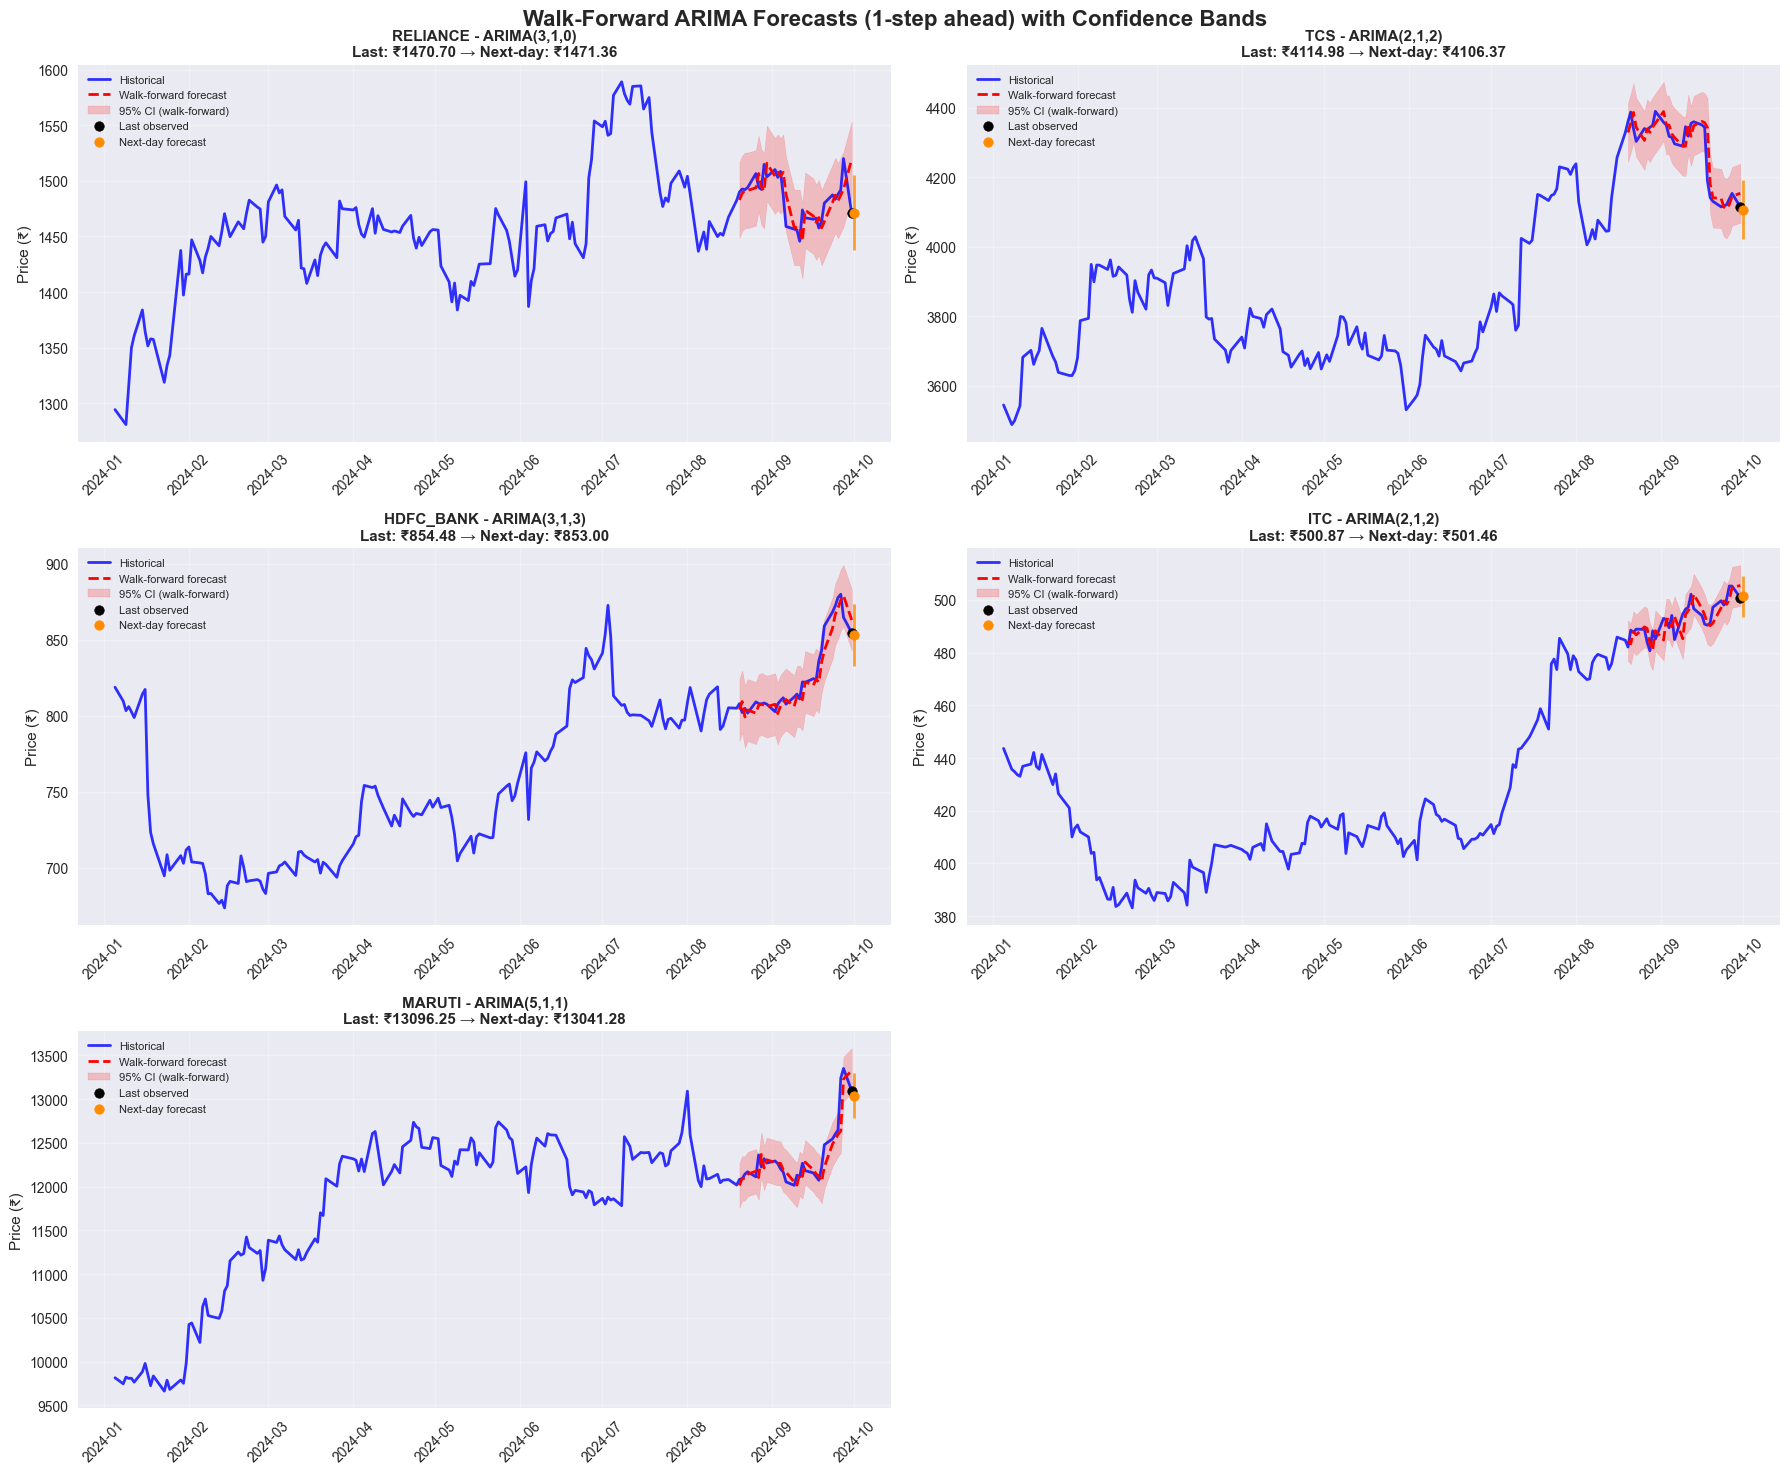

In [20]:
# Create visualizations for walk-forward forecasts
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('Walk-Forward ARIMA Forecasts (1-step ahead) with Confidence Bands', fontsize=16, fontweight='bold')

for i, (name, forecast_data) in enumerate(forecasts.items()):
    row = i // 2
    col = i % 2

    # Get historical data (last 6 months for better visualization)
    original_series = optimal_models[name]['original_series']
    recent_data = original_series.tail(180)  # Last ~6 months

    # Plot historical prices
    axes[row, col].plot(recent_data.index, recent_data.values,
                       color='blue', linewidth=2, label='Historical', alpha=0.8)

    # Plot walk-forward predictions (these align to historical timestamps)
    wf = forecast_data['walk_forecast']
    wl = forecast_data['walk_lower_ci']
    wu = forecast_data['walk_upper_ci']

    axes[row, col].plot(wf.index, wf.values,
                       color='red', linewidth=2, label='Walk-forward forecast', linestyle='--')

    axes[row, col].fill_between(wf.index, wl.values, wu.values,
                               color='red', alpha=0.2, label='95% CI (walk-forward)')

    # Mark the last observed point and next-day out-of-sample forecast
    axes[row, col].scatter([original_series.index[-1]], [forecast_data['last_price']],
                           color='black', zorder=5, label='Last observed')
    axes[row, col].scatter([forecast_data['next_date']], [forecast_data['next_forecast']],
                           color='darkorange', zorder=5, label='Next-day forecast')
    axes[row, col].vlines(forecast_data['next_date'], forecast_data['next_lower_ci'], forecast_data['next_upper_ci'],
                          color='darkorange', linewidth=2, alpha=0.8)

    # Formatting
    p, d, q = forecast_data['model_params']
    axes[row, col].set_title(
        f'{name} - ARIMA({p},{d},{q})\n'
        f'Last: ₹{forecast_data["last_price"]:.2f} → Next-day: ₹{forecast_data["next_forecast"]:.2f}',
        fontweight='bold', fontsize=11
    )
    axes[row, col].set_ylabel('Price (₹)')
    axes[row, col].legend(loc='upper left', fontsize=8)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].tick_params(axis='x', rotation=45)

# Hide the empty subplot (bottom right) if needed
if len(forecasts) == 5:
    axes[2, 1].axis('off')

plt.tight_layout()
plt.show()